In [ ]:
# # Step 3: Test Implementation vs MVT Predictions

# # Step 3a: Does increasing patch yield = longer staying time?
# increased_yields = np.linspace(1, 20, P)
# longer_stay_times = [compute_mvt_leave_time(Patch(yield_, decay_rate), background_reward_rate) for yield_ in increased_yields]

# plt.figure(figsize=(10, 6))
# plt.plot(increased_yields, longer_stay_times, label='MVT Predicted Stay Times')
# plt.xlabel('Patch Yield')
# plt.ylabel('Predicted Stay Time')
# plt.title('Effect of Increasing Patch Yield on Stay Time')
# plt.legend()
# plt.show()

# # Step 3b: Does a richer environment = shorter staying time?
# richer_environment = np.random.rand(P) * 20
# background_richer_rate = np.mean(richer_environment) * decay_rate
# shorter_stay_times = [compute_mvt_leave_time(Patch(yield_, decay_rate), background_richer_rate) for yield_ in initial_yields]

# plt.figure(figsize=(10, 6))
# plt.plot(initial_yields, shorter_stay_times, label='MVT Predicted Stay Times in Richer Environment')
# plt.xlabel('Patch Yield')
# plt.ylabel('Predicted Stay Time')
# plt.title('Effect of Richer Environment on Stay Time')
# plt.legend()
# plt.show()

# # Step 3c: Does the agent overharvest? If not, what would make it overharvest?
# def compute_agent_overharvest(patch, agent, leave_time):
#     patch.start_harvesting()
#     rewards = []
#     time = 0
#     while time < leave_time:
#         reward = patch.get_reward()
#         rewards.append(reward)
#         if agent.choose_action(rewards) == 1:
#             return True  # Agent leaves earlier than MVT prediction
#         time += 1
#     return False  # Agent stays as per MVT prediction

# overharvest_results = [compute_agent_overharvest(Patch(yield_, decay_rate), agent, leave_time) for yield_, leave_time in zip(initial_yields, longer_stay_times)]

# print(f"Agent Overharvest Results: {overharvest_results}")

# # Plot the results
# plt.plot(total_rewards)
# plt.xlabel('Patch Number')
# plt.ylabel('Total Reward')
# plt.title('Total Reward Collected from Each Patch')
# plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from world import Patch, Agent
from mvt_brr import MVTModel

In [40]:
model = MVTModel(decay_type='exponential')
mvt_rich, mvt_poor = model.run()

In [8]:
# Simulation function
def simulate(environment, agent, n_runs=1000, n_max=1000):
    leave_times = []
    for _ in range(n_runs):
        patch = Patch(environment['initial_yield'], environment['decay_rate'])
        patch.start_harvesting()
        for t in range(1, n_max+1):
            reward = patch.get_reward()
            action = agent.choose_action(reward)
            if action == 1:
                leave_times.append(t)
                break
    return leave_times

In [39]:
# Define environments
patch_types = [
    {'initial_yield': 32.5, 'decay_rate': 0.1},
    {'initial_yield': 45, 'decay_rate': 0.1},
    {'initial_yield': 57.5, 'decay_rate': 0.1}
]

# Proportions
rich_proportions = [0.2, 0.3, 0.5]
poor_proportions = [0.5, 0.3, 0.2]

In [87]:
# agent = Agent(beta=0.1, intercept=0)
# leave_times_rich = []
# leave_times_poor = []

# # Initialize counters for greater and less than
# rich_overharvest = [0] * len(mvt_rich)
# rich_underharvest = [0] * len(mvt_rich)
# poor_overharvest = [0] * len(mvt_poor)
# poor_underharvest = [0] * len(mvt_poor)

# for index, (patch, proportion) in enumerate(zip(patch_types, rich_proportions)):
#     leave_times = simulate(patch, agent, n_runs=int(1000 * proportion))
#     for value in leave_times:
#         if value > mvt_rich[index]:
#             rich_overharvest[index] += 1
#         elif value < mvt_rich[index]:
#             rich_underharvest[index] += 1
#     rich_overharvest[index] /= (1000 * proportion)

# for index, (patch, proportion) in enumerate(zip(patch_types, poor_proportions)):
#     leave_times = simulate(patch, agent, n_runs=int(1000 * proportion))
#     for value in leave_times:
#         if value > mvt_poor[index]:
#             poor_overharvest[index] += 1
#         elif value < mvt_poor[index]:
#             poor_underharvest[index] += 1

# print(rich_overharvest, rich_underharvest)
# print(poor_overharvest, poor_underharvest)

In [89]:
def run_simulation(agent, patch_types, proportions, mvt_values):
    """Run the simulation for a given agent and environment and count overharvest and underharvest events."""
    overharvest = [0] * len(mvt_values)
    underharvest = [0] * len(mvt_values)
    
    for index, (patch, proportion) in enumerate(zip(patch_types, proportions)):
        leave_times = simulate(patch, agent, n_runs=int(1000 * proportion))
        for value in leave_times:
            if value > mvt_values[index]:
                overharvest[index] += 1
            elif value < mvt_values[index]:
                underharvest[index] += 1
        overharvest[index] /= (1000*proportion)
        underharvest[index] /= (1000*proportion)
    return overharvest, underharvest

In [83]:
def plot_results(ax, beta, intercept, patch_types, rich_result, poor_result):
    """Plot the simulation results on given axes."""
    width = 0.35  # Width of the bars
    ind = np.arange(len(patch_types))  # X locations for the groups
    ax.bar(ind - width/2, rich_result, width, label='Rich')
    ax.bar(ind + width/2, poor_result, width, label='Poor')

    ax.set_title(f'Beta: {beta}, Intercept: {intercept}')
    ax.set_ylabel('Overharvest %')
    # ax.set_xticks(ind)
    ax.set_xticklabels([])
    ax.legend()

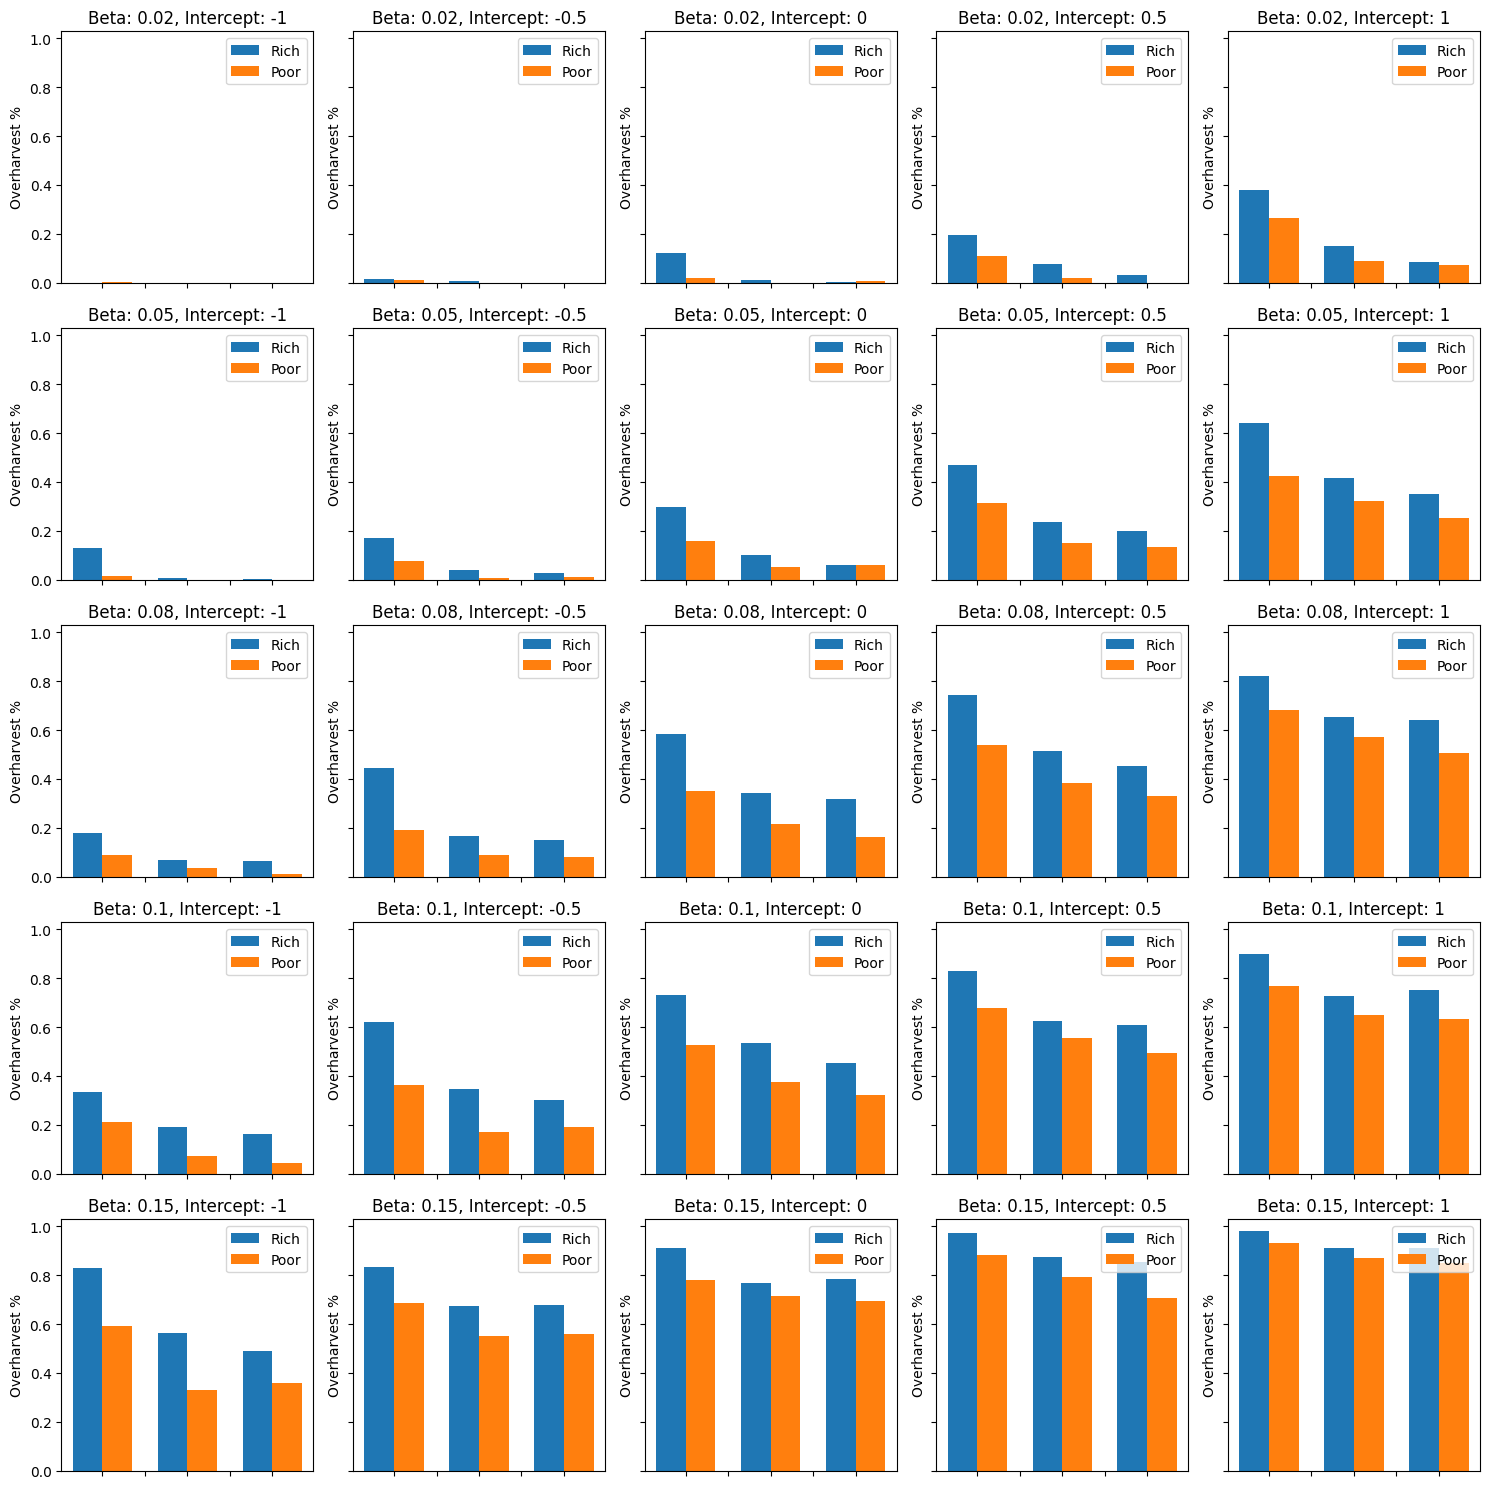

In [90]:
beta_values = [0.02, 0.05, 0.08, 0.1, 0.15]
intercept_values = [-1, -0.5, 0, 0.5, 1]

fig, axes = plt.subplots(len(beta_values), len(intercept_values), figsize=(15, 15), sharey=True)

for b_idx, beta in enumerate(beta_values):
    for i_idx, intercept in enumerate(intercept_values):
        agent = Agent(beta=beta, intercept=intercept)
        rich_overharvest, _ = run_simulation(agent, patch_types, rich_proportions, mvt_rich)
        poor_overharvest, _ = run_simulation(agent, patch_types, poor_proportions, mvt_poor)
        ax = axes[b_idx, i_idx]
        plot_results(ax, beta, intercept, patch_types, rich_overharvest, poor_overharvest)

fig.tight_layout()
plt.show()